# ОБУЧЕНИЕ СЕМАНТИЧЕСКОЙ СЕГМЕНТАЦИИ 

In [ ]:
%pip install opencv-python
%pip install segmentation-models-pytorch
%pip install albumentations

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import torch
import random 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import albumentations as albu
%matplotlib inline

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Параметры

In [3]:
DATSET_NAME = "camvid-dataset"

X_TRAIN_DIR = f"{DATSET_NAME}/Train"
Y_TRAIN_DIR = f"{DATSET_NAME}/Trainannot"

X_VALID_DIR = f"{DATSET_NAME}/Validation"
Y_VALID_DIR = f"{DATSET_NAME}/Validationannot"

X_TEST_DIR = f"{DATSET_NAME}/Validation"
Y_TEST_DIR = f"{DATSET_NAME}/Validationannot"

LABEL_COLORS_FILE = f"{DATSET_NAME}/label_colors.txt"

Задание констант:

In [70]:
CLASSES = [
    "background",
    "item"  
]
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 70
BATCH_SIZE = 32

INIT_LR = 0.0005
LR_DECREASE_STEP = 15
LR_DECREASE_COEF = 2

INFER_WIDTH = 256
INFER_HEIGHT = 256

loss = utils.losses.DiceLoss()

# Вспомогательные функции

In [71]:
def _convert_multichannel2singlechannel(mc_mask: np.ndarray):
    colors_imshow = {
            "background" : np.array([0, 0, 0]),
            "item" : np.array([87, 170, 197])
    }

    sc_mask = np.zeros((mc_mask[0].shape[0], mc_mask[0].shape[1], 3), dtype=np.uint8)
    square_ratios = {}

    for i, singlechannel_mask in enumerate(mc_mask):

        cls = CLASSES[i]
        singlechannel_mask = singlechannel_mask.squeeze()
        square_ratios[cls] = singlechannel_mask.sum() / singlechannel_mask.size
        
        sc_mask += np.multiply.outer(singlechannel_mask > 0, colors_imshow[cls]).astype(np.uint8)
        

    title = "Площади: " + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    return sc_mask, title


def visualize_multichennel_mask(img: np.ndarray, multichennel_mask: np.ndarray):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    multichennel_mask = multichennel_mask.transpose(2, 0, 1)
    mask_to_show, title = _convert_multichannel2singlechannel(multichennel_mask)
    axes[1].imshow(mask_to_show)
    axes[1].set_title(title)

    plt.tight_layout()
    plt.show()

# Dataloader

In [72]:
class Dataset(BaseDataset):
    def __init__(
        self,
        images_dir,
        masks_dir,
        augmentation=None,
        preprocessing=None
    ):
        self.images_paths = glob(f"{images_dir}/*")
        self.masks_paths = glob(f"{masks_dir}/*")

        self.cls_colors = self._get_classes_colors(LABEL_COLORS_FILE)

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def _get_classes_colors(self, label_colors_dir):
        cls_colors = {}
        with open(label_colors_dir) as file:
            while line := file.readline():
                R, G, B, label = line.rstrip().split()
                cls_colors[label] = np.array([B, G, R], dtype=np.uint8)

        keyorder = CLASSES
        cls_colors_ordered = {}
        for k in keyorder:
            if k in cls_colors:
                cls_colors_ordered[k] = cls_colors[k]
            elif k=="background":
                cls_colors_ordered[k] = np.array([0, 0, 0], dtype=np.uint8)
            else:
                raise ValueError(f"unexpected label {k}, cls colors: {cls_colors}")

        return cls_colors_ordered

    def __getitem__(self, i):
        image = cv2.imread(self.images_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_paths[i])
        masks = [cv2.inRange(mask, color, color) for color in self.cls_colors.values()]
        masks = [(m > 0).astype("float32") for m in masks]
        mask = np.stack(masks, axis=-1).astype("float")

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.images_paths)

Демонстрация случайных фотографий тренировочного датасета с их масками:

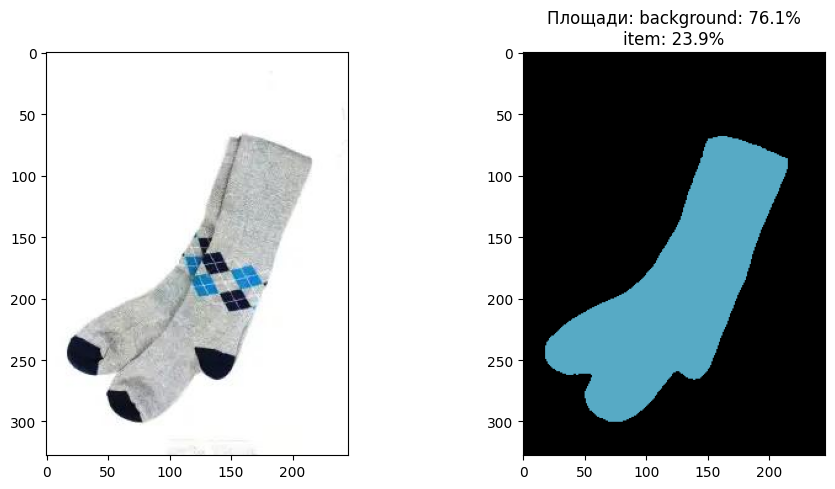

In [73]:
dataset = Dataset(X_TRAIN_DIR, Y_TRAIN_DIR)
image, mask = dataset[np.random.randint(len(dataset))]
visualize_multichennel_mask(image, mask)

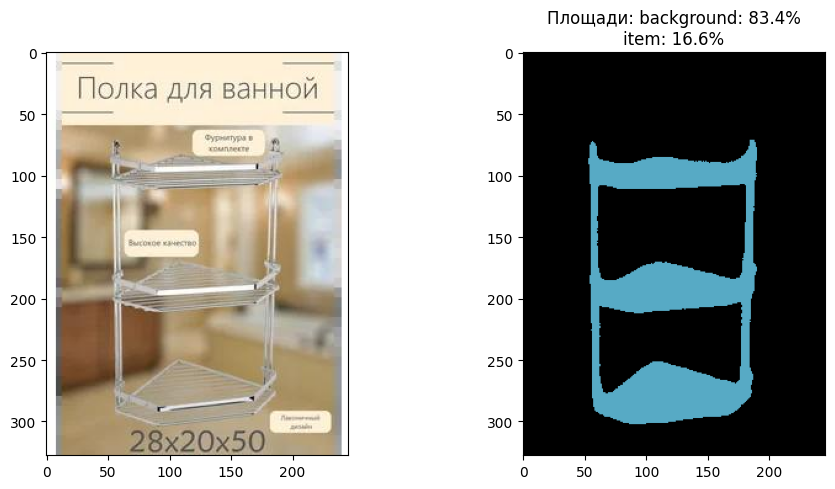

In [74]:
dataset2 = Dataset(X_VALID_DIR, Y_VALID_DIR)
image2, mask2 = dataset[np.random.randint(len(dataset))]
visualize_multichennel_mask(image2, mask2)

# Augmentations

In [75]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        #albu.SchiftScaleRotate()
        
        albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
        albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=1, always_apply=True),
        albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True),

        albu.OneOf(
            [
                albu.Sharpen(alpha=(0.1, 0.2), lightness=(0.1, 0.2), p=0.5),
                albu.Blur(blur_limit=[1, 3], p=0.5),
                albu.GaussNoise(var_limit=(1, 5), p=0.5),
            ],
            p=0.7,
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
                albu.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),
                albu.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5), 
            ],
            p=0.7,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=1, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Пример аугментаций на train:

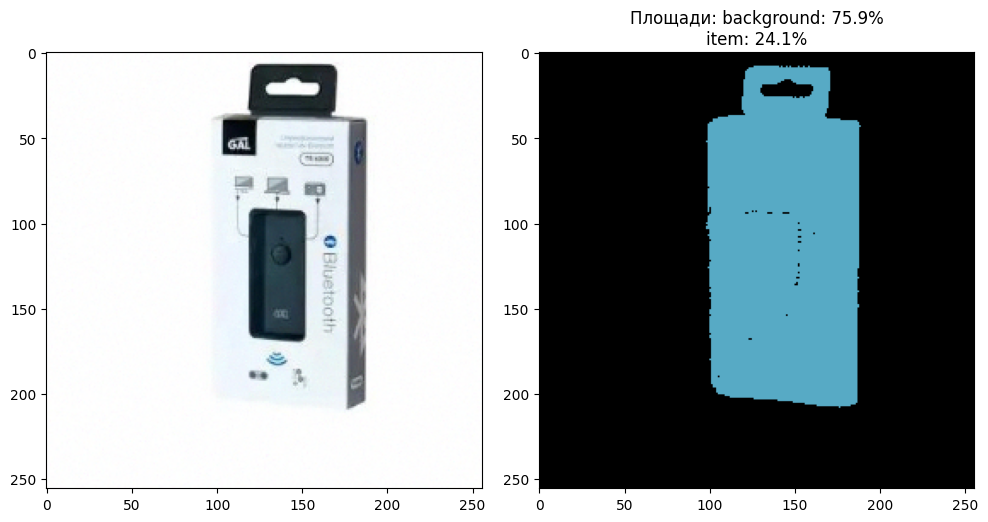

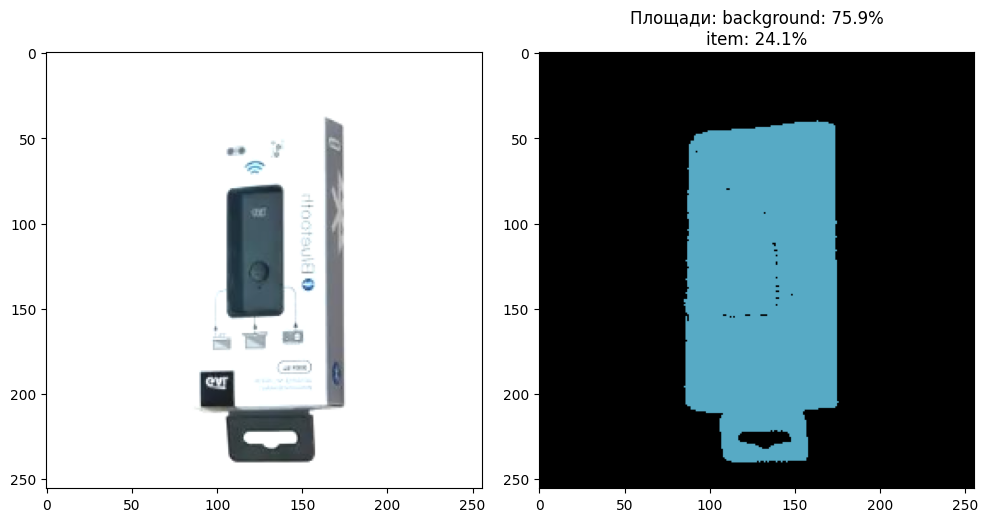

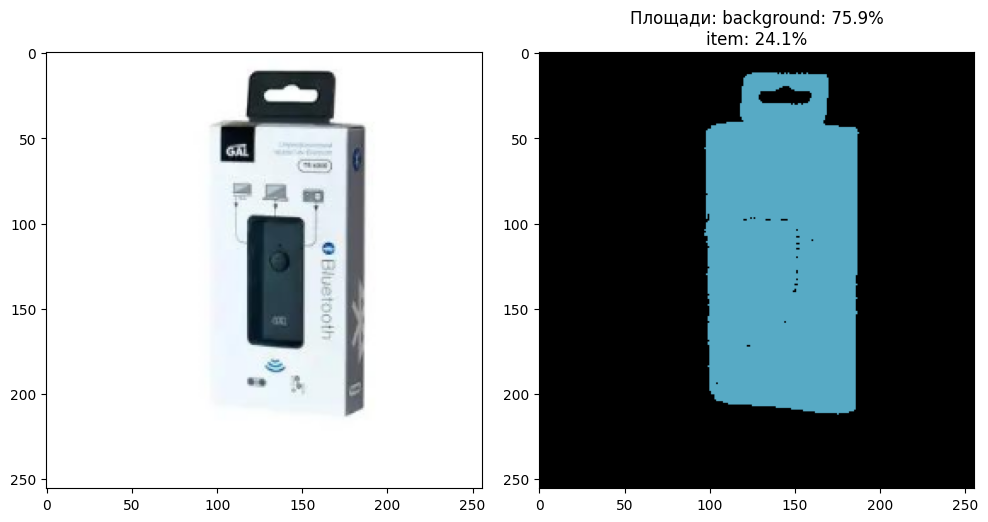

In [76]:
augmented_dataset = Dataset(
    X_TRAIN_DIR, 
    Y_TRAIN_DIR, 
    augmentation=get_training_augmentation()
)

# same image with different random transforms
indx = np.random.randint(len(augmented_dataset))

for i in range(3):
    image, mask = augmented_dataset[indx]
    visualize_multichennel_mask(image, mask)

Пример аугментаций на val:

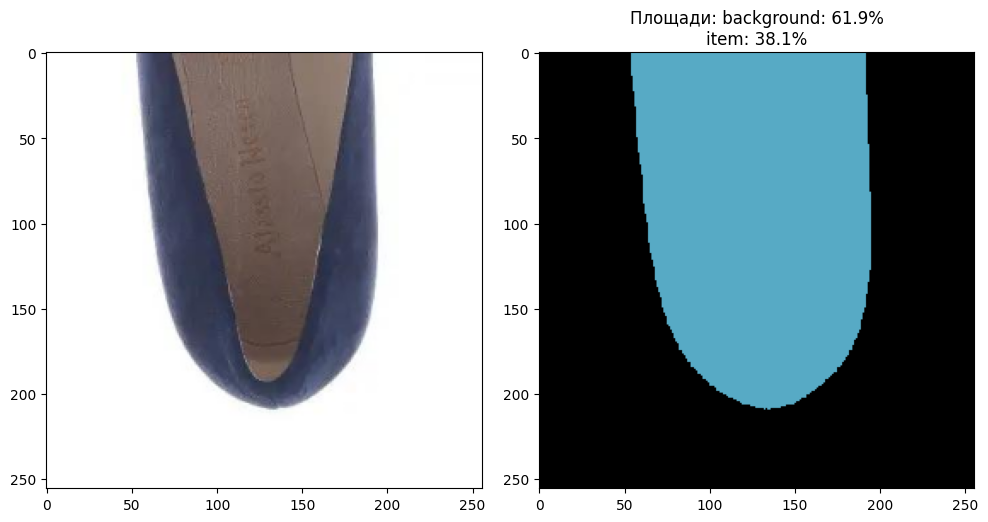

In [77]:
augmented_dataset = Dataset(
    X_VALID_DIR, 
    Y_VALID_DIR, 
    augmentation=get_validation_augmentation()
)

indx = np.random.randint(len(augmented_dataset))

image, mask = augmented_dataset[indx]
visualize_multichennel_mask(image, mask)

# Create model and train

In [78]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [79]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Загрузка нормализации от imagenet

In [80]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
#preprocessing_fn = lambda img, **kwargs: img.astype("float32") / 255    # или классика деление на 255

In [81]:
preprocessing_fn

functools.partial(<function preprocess_input at 0x00000250D82E0400>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [82]:
train_dataset = Dataset(
    X_TRAIN_DIR, 
    Y_TRAIN_DIR, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    X_VALID_DIR, 
    Y_VALID_DIR, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [83]:
metrics = [
    utils.metrics.Fscore(),
    utils.metrics.IoU()
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=INIT_LR),
])

In [84]:
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

Обучение:

In [85]:
max_score = 0

loss_logs = {"train": [], "val": []}
metric_logs = {"train": [], "val": []}
for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    train_loss, train_metric, train_metric_IOU = list(train_logs.values())
    loss_logs["train"].append(train_loss)
    metric_logs["train"].append(train_metric_IOU)

    valid_logs = valid_epoch.run(valid_loader)
    val_loss, val_metric, val_metric_IOU = list(valid_logs.values())
    loss_logs["val"].append(val_loss)
    metric_logs["val"].append(val_metric_IOU)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, 'models/best_model_new.pth')
        trace_image = torch.randn(BATCH_SIZE, 3, INFER_HEIGHT, INFER_WIDTH)
        traced_model = torch.jit.trace(model, trace_image.to(DEVICE))
        torch.jit.save(traced_model, 'models/best_model_new.pt')
        print('Model saved!')

    print("LR:", optimizer.param_groups[0]['lr'])
    if i > 0 and i % LR_DECREASE_STEP == 0:
        print('Decrease decoder learning rate')
        optimizer.param_groups[0]['lr'] /= LR_DECREASE_COEF


Epoch: 0
valid: 100%|██████████| 50/50 [00:01<00:00, 46.34it/s, dice_loss - 0.09719, fscore - 0.9156, iou_score - 0.866] 
Model saved!
LR: 0.0005

Epoch: 1
valid: 100%|██████████| 50/50 [00:01<00:00, 47.71it/s, dice_loss - 0.09889, fscore - 0.9076, iou_score - 0.8507]
LR: 0.0005

Epoch: 2
valid: 100%|██████████| 50/50 [00:01<00:00, 43.14it/s, dice_loss - 0.08285, fscore - 0.9205, iou_score - 0.8756]
Model saved!
LR: 0.0005

Epoch: 3
valid: 100%|██████████| 50/50 [00:01<00:00, 43.48it/s, dice_loss - 0.05441, fscore - 0.9491, iou_score - 0.915] 
Model saved!
LR: 0.0005

Epoch: 4
valid: 100%|██████████| 50/50 [00:01<00:00, 42.90it/s, dice_loss - 0.04367, fscore - 0.9596, iou_score - 0.93]  
Model saved!
LR: 0.0005

Epoch: 5
valid: 100%|██████████| 50/50 [00:01<00:00, 46.77it/s, dice_loss - 0.05802, fscore - 0.9449, iou_score - 0.9081]
LR: 0.0005

Epoch: 6
valid: 100%|██████████| 50/50 [00:01<00:00, 44.29it/s, dice_loss - 0.06252, fscore - 0.9395, iou_score - 0.909] 
LR: 0.0005

Epoch: 7


Оценка обучения:

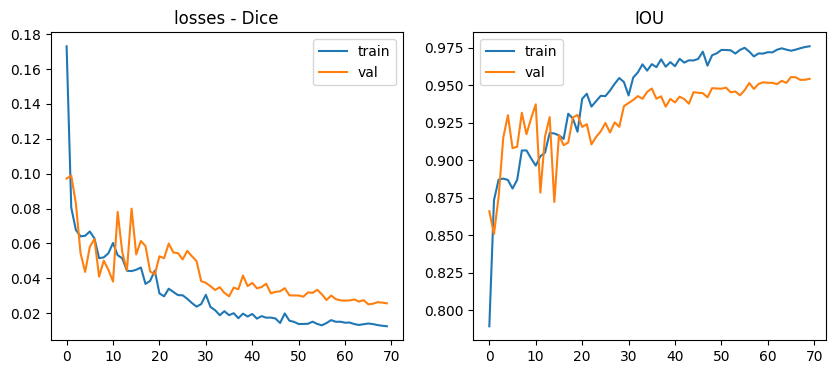

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(loss_logs["train"], label = "train")
axes[0].plot(loss_logs["val"], label = "val")
axes[0].set_title("losses - Dice")

axes[1].plot(metric_logs["train"], label = "train")
axes[1].plot(metric_logs["val"], label = "val")
axes[1].set_title("IOU")

[ax.legend() for ax in axes];

В целом объяснимы такие графики за счёт малости датасета и ужаса данных и разметки. В валидационные были выбраны и хорошие и плохие фото, но видимо плохих чуть меньше. (я пытался чутка переложить данные, но картина меняется не сильно, нельзя оставить только плохие на валидации)

# Test best saved model

In [87]:
# load best saved checkpoint
#best_model = torch.load('models/best_model_new.pth')
best_model = torch.jit.load('models/best_model_new.pt', map_location=DEVICE)

In [88]:
def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=1, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)

In [89]:
# оценка IoU
test_dataset = Dataset(
    X_TEST_DIR, 
    Y_TEST_DIR, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

test_dataloader = DataLoader(test_dataset)

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 50/50 [00:01<00:00, 28.69it/s, dice_loss - 0.02511, fscore - 0.9752, iou_score - 0.9555] 


# Visualize predictions

In [90]:
colors_imshow = {
        "background" : np.array([0, 0, 0]),
        "item" : np.array([87, 170, 197])
    }


def _colorize_mask(mask: np.ndarray):
    mask = mask.squeeze()
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    square_ratios = {}
    for cls_code, cls in enumerate(CLASSES):
        cls_mask = mask == cls_code
        square_ratios[cls] = cls_mask.sum() / cls_mask.size
        colored_mask += np.multiply.outer(cls_mask, colors_imshow[cls]).astype(np.uint8)

    return colored_mask, square_ratios


def reverse_normalize(img, mean, std):
    img = img * np.array(std) + np.array(mean)
    return img


def visualize_predicts(img: np.ndarray, mask_gt: np.ndarray, mask_pred: np.ndarray, normalized=False):
    # размер img: H, W, CHANNEL
    # размер mask_gt, mask_pred: H, W, значения - range(len(CLASSES)
    _, axes = plt.subplots(1, 3, figsize=(10, 5))
    img = img.transpose(1, 2, 0)
    if normalized:
        img = reverse_normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    axes[0].imshow(img)

    mask_gt, square_ratios = _colorize_mask(mask_gt)
    title = "Площади:\n" + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    axes[1].imshow(mask_gt, cmap="twilight")
    axes[1].set_title(f"GT маска\n" + title)

    mask_pred, square_ratios = _colorize_mask(mask_pred)
    title = "Площади:\n" + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    axes[2].imshow(mask_pred, cmap="twilight")
    axes[2].set_title(f"PRED маска\n" + title)

    plt.tight_layout()
    plt.show()

(256, 256) (3, 256, 256) (2, 256, 256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.288818357065736e-08..1.0000000236034394].


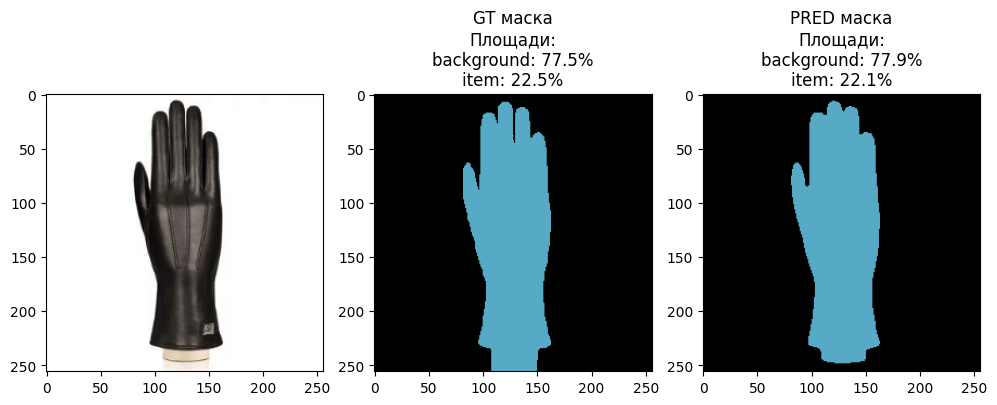

In [91]:
for i in range(1):
    n = np.random.choice(len(test_dataset))
    
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().detach().numpy()
    
    label_mask = np.argmax(pr_mask, axis=0)
    print(label_mask.shape, image.shape, gt_mask.shape)

    visualize_predicts(image, np.argmax(gt_mask, axis=0), label_mask, normalized=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.288818357065736e-08..0.9999999964237213].


(256, 256) (3, 256, 256) (2, 256, 256)


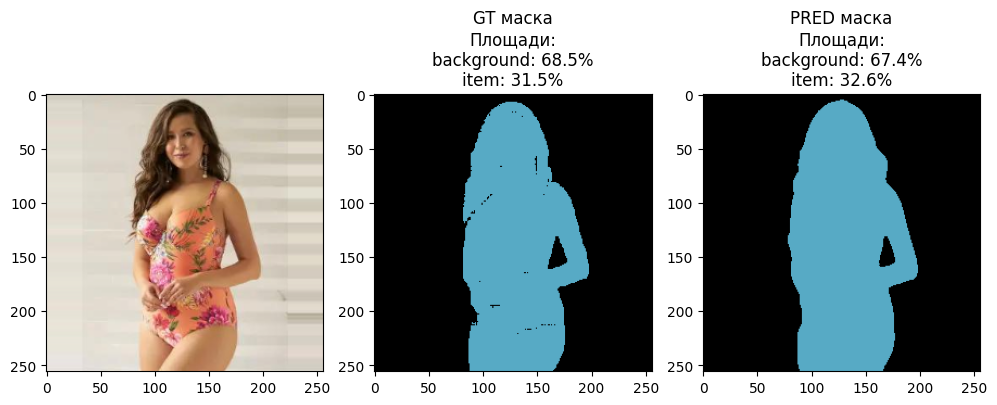

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.288818357065736e-08..1.0000000236034394].


(256, 256) (3, 256, 256) (2, 256, 256)


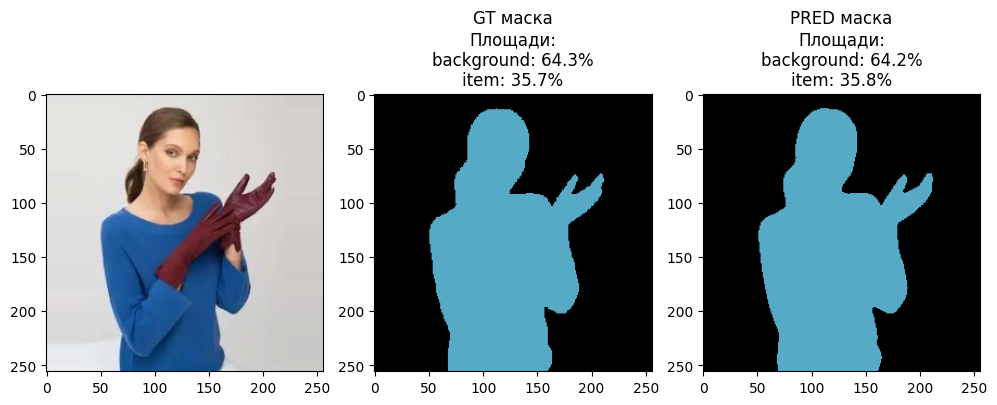

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.003921541452407806..1.0000000236034394].


(256, 256) (3, 256, 256) (2, 256, 256)


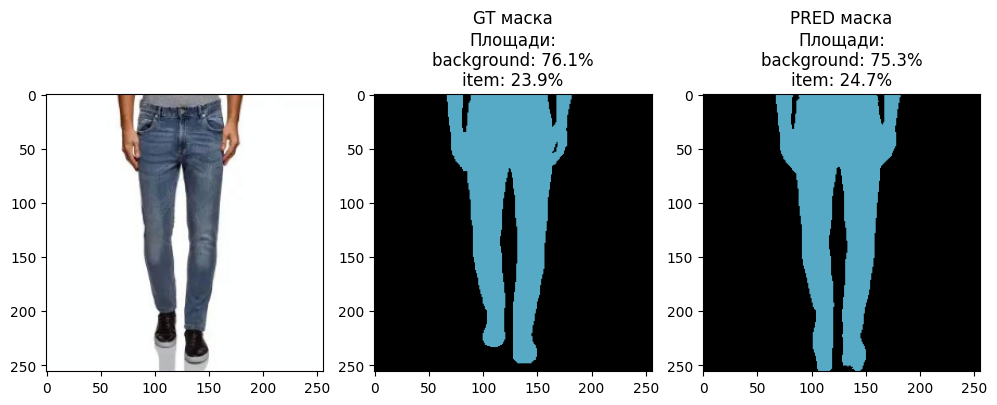

In [93]:
for i in range(3):
    n = np.random.choice(len(test_dataset))
    
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().detach().numpy()
    
    label_mask = np.argmax(pr_mask, axis=0)
    print(label_mask.shape, image.shape, gt_mask.shape)

    visualize_predicts(image, np.argmax(gt_mask, axis=0), label_mask, normalized=True)

Заметим что модель даже лучше сегментирует изображение чем это получилось при разметке. Она ищет общую закономерность и получаются лучше границы.
